# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from itertools import product
import pickle

The neural network parameters will be stored in a dictionary (`model` below), where the keys are the parameter names and the values are numpy arrays. Below, we initialize toy data and a toy model that we will use to verify your implementations.

In [3]:
# Create some toy data to check your implementations
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    model = {}
    model['W1'] = np.linspace(-0.2, 0.6, num=input_size*hidden_size).reshape(input_size, hidden_size)
    model['b1'] = np.linspace(-0.3, 0.7, num=hidden_size)
    model['W2'] = np.linspace(-0.4, 0.1, num=hidden_size*num_classes).reshape(hidden_size, num_classes)
    model['b2'] = np.linspace(-0.5, 0.9, num=num_classes)
    return model

def init_toy_data():
    X = np.linspace(-0.2, 0.5, num=num_inputs*input_size).reshape(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

model = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the function `two_layer_net`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [4]:
from cs231n.classifiers.neural_net import two_layer_net

scores = two_layer_net(X, model)
print(scores)
correct_scores = [[-0.5328368, 0.20031504, 0.93346689],
 [-0.59412164, 0.15498488, 0.9040914 ],
 [-0.67658362, 0.08978957, 0.85616275],
 [-0.77092643, 0.01339997, 0.79772637],
 [-0.89110401, -0.08754544, 0.71601312]]

# the difference should be very small. We get 3e-8
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

[[-0.5328368   0.20031504  0.93346689]
 [-0.59412164  0.15498488  0.9040914 ]
 [-0.67658362  0.08978957  0.85616275]
 [-0.77092643  0.01339997  0.79772637]
 [-0.89110401 -0.08754544  0.71601312]]
Difference between your scores and correct scores:
3.84868230029e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [5]:
reg = 0.1
loss, _ = two_layer_net(X, model, y, reg)
print(loss)
correct_loss = 1.38191946092

# should be very small, we get 5e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

1.38191946092
Difference between your loss and correct loss:
4.67692551354e-12


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [6]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = two_layer_net(X, model, y, reg)

# these should all be less than 1e-8 or so
for param_name in grads:
    param_grad_num = eval_numerical_gradient(
        lambda W: two_layer_net(X, model, y, reg)[0],
        model[param_name], 
        verbose=False
    )
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b1 max relative error: 2.027454e-08
b2 max relative error: 2.720082e-11
W2 max relative error: 3.379922e-09
W1 max relative error: 4.426512e-09


# Train the network
To train the network we will use SGD with Momentum. Last assignment you implemented vanilla SGD. You will now implement the momentum update and the RMSProp update. Open the file `classifier_trainer.py` and familiarze yourself with the `ClassifierTrainer` class. It performs optimization given an arbitrary cost function data, and model. By default it uses vanilla SGD, which we have already implemented for you. First, run the optimization below using Vanilla SGD:

In [7]:
from cs231n.classifier_trainer import ClassifierTrainer

model = init_toy_model()
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.0, learning_rate_decay=1,
                                             update='sgd', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
print('Final loss with vanilla SGD: %f' % (loss_history[-1], ))

starting iteration  0
starting iteration  50
Final loss with vanilla SGD: 0.940686


Now fill in the **momentum update** in the first missing code block inside the `train` function, and run the same optimization as above but with the momentum update. You should see a much better result in the final obtained loss:

In [8]:
model = init_toy_model()
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.494394
print('Final loss with momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  50
Final loss with momentum SGD: 0.494394. We get: 0.494394


Now also implement the **RMSProp** update rule inside the `train` function and rerun the optimization:

In [9]:
model = init_toy_model()
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='rmsprop', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.439368
print('Final loss with RMSProp: %f. We get: %f' % (loss_history[-1], correct_loss))

starting iteration  0
starting iteration  50
Final loss with RMSProp: 0.439368. We get: 0.439368


# Load the data
Now that you have implemented a two-layer network that passes gradient checks, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier.

In [10]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [27]:
from IPython.html import widgets
from IPython.display import display as ipydisplay
from cs231n.vis_utils import ParametersInspectorWindow

In [12]:
from cs231n.classifiers.neural_net import init_two_layer_model

w = widgets.IntProgress()
ipydisplay(w)

model = init_two_layer_model(32*32*3, 50, 10) # input size, hidden size, number of classes
trainer = ClassifierTrainer()
best_model, loss_history, train_acc, val_acc = trainer.train(
    X_train, y_train, X_val, y_val,
    model, two_layer_net,
    # parameters to be tuned
    num_epochs=5, reg=1.0,
    momentum=0.9, learning_rate_decay = 0.95,
    learning_rate=1e-5, 
    # end of parameters
    progress_bar=w, verbose=True
)

Finished epoch 0 / 5: cost 2.302593, train: 0.072000, val 0.087000, lr 1.000000e-05
Finished epoch 1 / 5: cost 2.281877, train: 0.172000, val 0.177000, lr 9.500000e-06
Finished epoch 2 / 5: cost 2.051484, train: 0.233000, val 0.241000, lr 9.025000e-06
Finished epoch 3 / 5: cost 2.005413, train: 0.300000, val 0.291000, lr 8.573750e-06
Finished epoch 4 / 5: cost 1.897516, train: 0.353000, val 0.338000, lr 8.145063e-06
Finished epoch 5 / 5: cost 1.969680, train: 0.360000, val 0.369000, lr 7.737809e-06
finished optimization. best validation accuracy: 0.369000


In [13]:
train_acc, val_acc

([0.071999999999999995,
  0.17199999999999999,
  0.23300000000000001,
  0.29999999999999999,
  0.35299999999999998,
  0.35999999999999999],
 [0.086999999999999994,
  0.17699999999999999,
  0.24099999999999999,
  0.29099999999999998,
  0.33800000000000002,
  0.36899999999999999])

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.37 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

In [14]:
# Plot the loss function and train / validation accuracies
def vis_history(loss_history, train_acc, val_acc):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(loss_history)
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    return fig

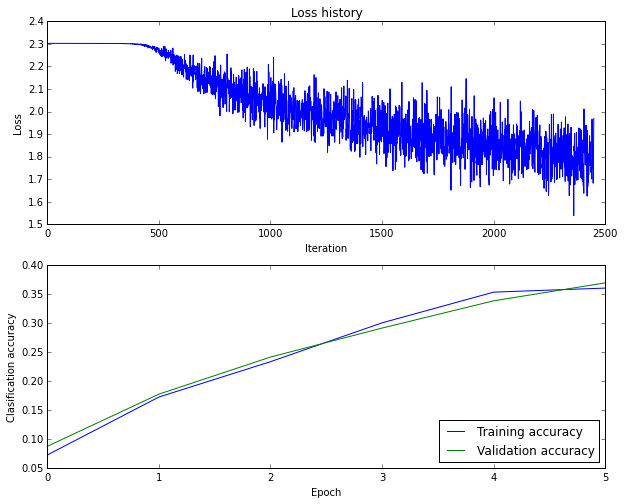

In [15]:
fig = vis_history(loss_history, train_acc, val_acc)

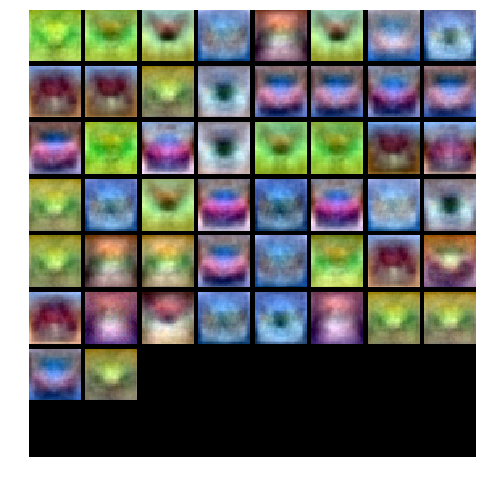

In [16]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(model):
    plt.imshow(visualize_grid(model['W1'].T.reshape(-1, 32, 32, 3), padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(best_model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the momentum and learning rate decay parameters, but you should be able to get good performance using the default values.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 50% on the validation set. Our best network gets over 56% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 56% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [40]:
params_pool = {
    'hidden_size': [50],
    'num_epochs': [5],
    'reg': [1.0, 0.5],
    'learning_rate': [1e-5],
}

for params in product(*params_pool.values()):
    current_params = {
        param: param_val
        for param, param_val in zip(params_pool.keys(), params)
    }
    # for param, param_val in zip(params_pool.keys(), params):
    #     print(param, '=', param_val, end=', ')
    print(current_params)

{'hidden_size': 50, 'num_epochs': 5, 'reg': 1.0, 'learning_rate': 1e-05}
{'hidden_size': 50, 'num_epochs': 5, 'reg': 0.5, 'learning_rate': 1e-05}


In [45]:
def parameter_space(params_pool):
    """yield paramter swapping all given possibilities."""
    for params in product(*params_pool.values()):
        current_params = {
            param: param_val
            for param, param_val in zip(params_pool.keys(), params)
        }
        yield current_params

In [30]:
w_param = ParametersInspectorWindow(get_ipython(), None)
ipydisplay(w_param)
w_param.detach()

<IPython.core.display.Javascript object>

In [46]:
%%capture --no-display cross_val_msg
best_model = None # store the best model into this
swap_params_history = []
swap_perf_history = []
best_val_acc = 0.0
params_space = {
    'hidden_size': [25, 50, 75, 100],
    'num_epochs': [20],
    'reg': [0, 0.2, 1, 5],
    'learning_rate': [5e-5, 1e-4, 5e-4],
    'update': ['rmsprop', 'momentum'],
    'batch_size': [100, 200, 500],
}
# good: 50, 10, 1, 2.5e-4 (batch_size=200)
# init progress bar
w = widgets.IntProgress()
ipydisplay(w)

swap_space = list(parameter_space(params_space))
for swap_th, params in enumerate(swap_space, 1):
    print('Training with', params)
    w.description = '[%d/%d]' % (swap_th, len(swap_space))
    w_param.value = params
    # (input size, hidden size, number of classes)
    model = init_two_layer_model(32*32*3, params['hidden_size'], 10) 
    remained_params = {k: v for k, v in params.items() if k not in ['hidden_size']}
    trainer = ClassifierTrainer()
    model, loss_history, train_acc, val_acc = trainer.train(
        X_train, y_train, X_val, y_val,
        model, two_layer_net,
        # update='rmsprop',
        # batch_size=200,
        momentum=0.9, learning_rate_decay = 0.95,
        progress_bar=w, verbose=True,
        # parameters to be cross-validated
        **remained_params
    )
    if val_acc[-1] > best_val_acc:
        best_model = model
        best_val_acc = val_acc[-1]
    
    # stored model result
    swap_params_history.append(params)
    swap_perf_history.append({
        'loss_history': loss_history,
        'train_acc': train_acc,
        'val_acc': val_acc
    })
    print('-' * 24)

In [47]:
with open('cross_val_models.pickle3', 'wb') as f:
    pickle.dump({
        'params': swap_params_history,
        'perf': swap_perf_history,
    }, f)

In [ ]:
cross_val_msg.show()

## Visualize

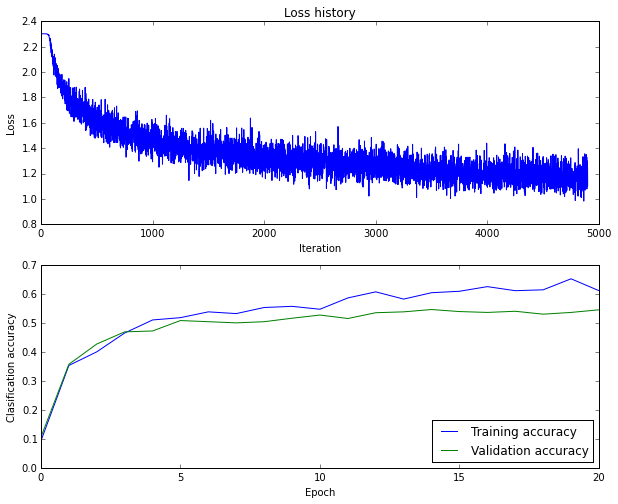

In [66]:
fig = vis_history(**swap_perf_history[166])

In [52]:
swap_params_history[0]

{'batch_size': 100,
 'hidden_size': 25,
 'learning_rate': 5e-05,
 'num_epochs': 20,
 'reg': 0,
 'update': 'rmsprop'}

In [64]:
list(
    (it, params, perf['val_acc'][-5:])
    for it, (params, perf) in enumerate(zip(swap_params_history, swap_perf_history)) if any(acc > 0.54 for acc in perf['val_acc'])
)

[(9,
  {'batch_size': 100,
   'hidden_size': 100,
   'learning_rate': 5e-05,
   'num_epochs': 20,
   'reg': 0,
   'update': 'rmsprop'},
  [0.51400000000000001,
   0.51000000000000001,
   0.54200000000000004,
   0.52100000000000002,
   0.51800000000000002]),
 (21,
  {'batch_size': 100,
   'hidden_size': 100,
   'learning_rate': 5e-05,
   'num_epochs': 20,
   'reg': 0.2,
   'update': 'rmsprop'},
  [0.53400000000000003,
   0.53500000000000003,
   0.53700000000000003,
   0.54100000000000004,
   0.53800000000000003]),
 (69,
  {'batch_size': 100,
   'hidden_size': 100,
   'learning_rate': 5e-05,
   'num_epochs': 20,
   'reg': 0.2,
   'update': 'momentum'},
  [0.54100000000000004,
   0.52900000000000003,
   0.53800000000000003,
   0.53800000000000003,
   0.53900000000000003]),
 (117,
  {'batch_size': 200,
   'hidden_size': 100,
   'learning_rate': 5e-05,
   'num_epochs': 20,
   'reg': 0.2,
   'update': 'rmsprop'},
  [0.52900000000000003,
   0.52100000000000002,
   0.52000000000000002,
   0.52

In [50]:
with open('cross_val_models.pickle3', 'rb') as f:
    his = pickle.load(f)

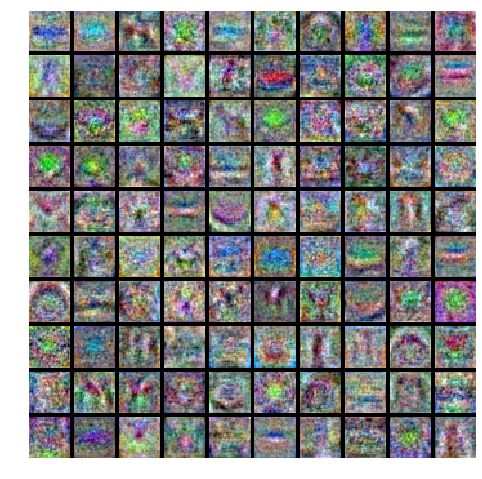

In [65]:
# visualize the weights
show_net_weights(best_model)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set. 

**We will give you extra bonus point for every 1% of accuracy above 56%.**

In [67]:
scores_test = two_layer_net(X_test, best_model)
print('Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test))

Test accuracy:  0.525
